# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss_event','win_event', 'neut_event']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


# download BH/neural data
# split data by condition(according BH data)
# Select ROI and split neural data by ROI


In [ ]:
import numpy as np

In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

Gambling data load

In [ ]:
#@title
braindata_gam=np.load('/content/hcp_task/subjects/100307/GAMBLING/tfMRI_GAMBLING_RL/data.npy')
braindata_gam.shape

(360, 253)

Emotion data load

In [ ]:
#@title
braindata_em=np.load('/content/hcp_task/subjects/100307/EMOTION/tfMRI_EMOTION_LR/data.npy')
braindata_em.shape

(360, 176)

# Loading the data for Gambling Task & Emotion Task
## extracting big ROIs and their parcels

In [ ]:
roidata=np.load('/content/hcp_task/regions.npy')
def makingBigroi():
  """Extract Subject data for each task experiment(Gambling/Emotion)

  Returns
    Rbigroi,Lbigroi,BigroiOrder_left,BigroiOrder_left: the name of big ROIs for right & left hemispheres & their order

  """
  Rbigroi={}
  BigroiOrder_right=[]
  idx=0
  for roi in roidata[:180]:
    if roi[1] not in Rbigroi.keys():
      Rbigroi[roi[1]]=[[roi[0],int(idx)]]
    else:
      Rbigroi[roi[1]]+=[[roi[0],int(idx)]]
    idx+=1
    BigroiOrder_right.append(roi[1])
  for i in Rbigroi:
    print(i,len(Rbigroi[i]))
  print()
  Lbigroi={}
  idx=0
  BigroiOrder_left=[]
  for roi in roidata[180:]:
    if roi[1] not in Lbigroi.keys():
      Lbigroi[roi[1]]=[[roi[0],int(idx)]]
    else:
      Lbigroi[roi[1]]+=[[roi[0],int(idx)]]
    idx+=1
    BigroiOrder_left.append(roi[1])
  for i in Lbigroi:
    print(i,len(Lbigroi[i]))
  return Rbigroi,Lbigroi,BigroiOrder_left,BigroiOrder_left



def ExtractsubjBraindata(subjnum):
  """Extract Subject data for each task experiment(Gambling/Emotion)

  Args:
    subjnum (str): subject ID

  Returns
    [braindata_gam_roi,braindata_em_roi]: brain data of the subject for Gambling & Emotion task based on big roi number & hemisphere

  """
  braindata_gam=np.load('/content/hcp_task/subjects/'+subjnum+'/GAMBLING/tfMRI_GAMBLING_LR/data.npy')
  braindata_gam/=np.mean(braindata_gam,axis=1)[:,None]

  braindata_gam2=np.load('/content/hcp_task/subjects/'+subjnum+'/GAMBLING/tfMRI_GAMBLING_RL/data.npy')
  braindata_gam2/=np.mean(braindata_gam2,axis=1)[:,None]

  braindata_em=np.load('/content/hcp_task/subjects/'+subjnum+'/EMOTION/tfMRI_EMOTION_LR/data.npy')
  braindata_em/=np.mean(braindata_em,axis=1)[:,None]

  braindata_em2=np.load('/content/hcp_task/subjects/'+subjnum+'/EMOTION/tfMRI_EMOTION_RL/data.npy')
  braindata_em2/=np.mean(braindata_em2,axis=1)[:,None]

  braindata_gam_roi=[[],[]]
  for bigroi in Rbigroi:
    temp=np.array(Rbigroi[bigroi])[:,1].reshape(-1).astype(int)
    braindata_gam_roi[0].append(np.concatenate((braindata_gam[temp],braindata_gam2[temp]),axis=1))
  for bigroi in Lbigroi:
    temp=np.array(Rbigroi[bigroi])[:,1].reshape(-1).astype(int)
    braindata_gam_roi[1].append(np.concatenate((braindata_gam[temp+180],braindata_gam2[temp+180]),axis=1))

  braindata_em_roi=[[],[]]
  for bigroi in Rbigroi:
    temp=np.array(Rbigroi[bigroi])[:,1].reshape(-1).astype(int)
    braindata_em_roi[0].append(np.concatenate((braindata_em[temp],braindata_em2[temp]),axis=1))
  for bigroi in Lbigroi:
    temp=np.array(Rbigroi[bigroi])[:,1].reshape(-1).astype(int)
    braindata_em_roi[1].append(np.concatenate((braindata_em[temp+180],braindata_em2[temp+180]),axis=1))
  return [braindata_gam_roi,braindata_em_roi]


Rbigroi,Lbigroi,BigroiOrder_left,BigroiOrder_left= makingBigroi()

subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

###### iterate for each subj #####
TotalDataSet=[] # the total dataset consisting of the data for Gambling & Emotion task for each subject
for subjnum in subjNlist:
  TotalDataSet.append(ExtractsubjBraindata(subjnum))


Visual1 3
Visual2 27
Somatomotor 19
Cingulo-Oper 27
Language 12
Default 14
Frontopariet 22
Auditory 8
Dorsal-atten 3
Posterior-Mu 40
Orbito-Affec 3
Ventral-Mult 2

Visual1 3
Visual2 27
Somatomotor 20
Cingulo-Oper 29
Default 9
Frontopariet 28
Auditory 7
Dorsal-atten 4
Posterior-Mu 37
Language 11
Orbito-Affec 3
Ventral-Mult 2


In [ ]:
LtoRconvert=[0,1,2,3,9,4,5,6,7,8,10,11] # equalizing the index of ROIs for both hemisphe

`TotalDataSet[subject index][Task -> 0:gambling , 1: Emotion][Hemisphere -> 0:right , 1:left][Big ROI index][small ROI index]`
**--> contains the data for both runs (run1 + run2)**

In [ ]:
print(len(TotalDataSet[1][0][0][4][0])) # subjN ;  gam=0, emotion=1 ; RH = 0, LH =1 ; eachBogROI_num ; smallROI_order ;timeseries (run1 + run2 )

506


## showing the BOLD signals of some trials of the second subject as an example

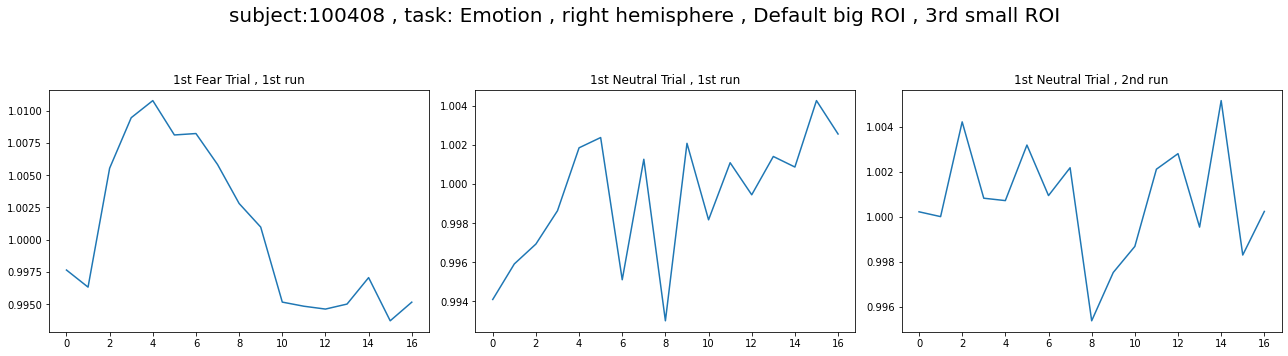

In [ ]:
fig, ax = plt.subplots(1, 3)#,gridspec_kw={'width_ratios':[10,10,10]})
fig.set_size_inches(18, 5)
ax[0].plot(TotalDataSet[1][1][0][5][2][32:49])
ax[0].title.set_text(f'1st Fear Trial , 1st run')
ax[1].plot(TotalDataSet[1][1][0][5][2][11:28])
ax[1].title.set_text(f'1st Neutral Trial , 1st run')
ax[2].plot(TotalDataSet[1][1][0][5][2][11+176:28+176])
ax[2].title.set_text(f'1st Neutral Trial , 2nd run')

plt.suptitle(f'subject:{subjNlist[1]} , task: Emotion , right hemisphere , Default big ROI , 3rd small ROI',fontsize=20)

plt.tight_layout()
fig.subplots_adjust(top=0.75)

plt.show()

In [ ]:
loss_r1 = np.array([8.063,11.688,18.899,26.109,29.708,33.319,95.827,99.439,106.663,113.887,117.485,121.097,146.927,154.164])/0.72
loss_r2 = np.array([15.287,55.577,59.189,62.788,70.011,73.623,77.235,95.854,99.466,103.078,110.315,117.539,121.137,146.953,154.164])/0.72+253
win_r1=np.array([15.3,22.511,51.925,59.149,62.774,66.386,69.998,77.222,103.051,110.275,139.703,143.315,150.552,157.776,161.388])/0.72
win_r2=np.array([164.986-253,8.063,11.675,18.899,22.524,26.136,33.359,51.965,139.73,143.342,150.552,157.776,161.388,164.986])/0.72+253

conds=[loss_r1[:7],loss_r1[7:14],loss_r2[:7],loss_r2[7:14],win_r1[:7],win_r1[7:14],win_r2[:7],win_r2[7:14]]

test = np.zeros((100,2,2,12,2))
timelist=[]
for i in range(2): # task
  task = i
  if i == 0: # gambling task (t1 to t4 are loss trials of run1 and run2; t5 to t8 are win trials, run1 and run2)
    for order in range(8):
      temp=np.arange(np.ceil(conds[order][0])+2,np.ceil(conds[order][0])+5)
      for num in conds[order][1:]:
        temp=np.concatenate((temp,np.arange(np.ceil(num)+2,np.ceil(num)+5)))
      timelist.append(temp[:])
    t1=timelist[0] #loss1
    t2=timelist[1] #loss2
    t3=timelist[2] #loss3
    t4=timelist[3] #loss4
    t5=timelist[4] #win1
    t6=timelist[5] #win2
    t7=timelist[6] #win3
    t8=timelist[7] #win4

  else: # emotion task (t1 to t4 are neutral trials of run1 and run2; t5 to t8 are fear trials, run1 and run2)

    t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
    t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
    t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
    t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')
    t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
    t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
    t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
    t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')

In [ ]:
t3

array([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216])

In [ ]:
### Srijita's code for generalizing RDM calculation (8 by 8 RDM matrices for each subject, task, hemisphere, ROI)
### save all possible RDMs in "RDM_store" variable

def RDM(subID, task, hemi, bRoi, t1, t2, t3, t4, t5, t6, t7, t8):
  if task==0:
    data = TotalDataSet[subID][0][hemi][bRoi]
    x1 = np.array(data)[:,t5].reshape(-1)
    x2 = np.array(data)[:,t6].reshape(-1)
    x3 = np.array(data)[:,t7].reshape(-1)
    x4 = np.array(data)[:,t8].reshape(-1)
    x5 = (np.array(data)[:,t1].reshape(-1)+np.array(data)[:,t5].reshape(-1))/2
    x6 = (np.array(data)[:,t2].reshape(-1)+np.array(data)[:,t6].reshape(-1))/2
    x7 = (np.array(data)[:,t3].reshape(-1)+np.array(data)[:,t7].reshape(-1))/2
    x8 = (np.array(data)[:,t4].reshape(-1)+np.array(data)[:,t8].reshape(-1))/2

  elif task==1:
    data = TotalDataSet[subID][0][hemi][bRoi]
    x1 = np.array(data)[:,t1].reshape(-1)
    x2 = np.array(data)[:,t2].reshape(-1)
    x3 = np.array(data)[:,t3].reshape(-1)
    x4 = np.array(data)[:,t4].reshape(-1)
    x5 = (np.array(data)[:,t1].reshape(-1)+np.array(data)[:,t5].reshape(-1))/2
    x6 = (np.array(data)[:,t2].reshape(-1)+np.array(data)[:,t6].reshape(-1))/2
    x7 = (np.array(data)[:,t3].reshape(-1)+np.array(data)[:,t7].reshape(-1))/2
    x8 = (np.array(data)[:,t4].reshape(-1)+np.array(data)[:,t8].reshape(-1))/2
  elif task==2:
    data = TotalDataSet[subID][1][hemi][bRoi]
    x1 = np.array(data)[:,t1].reshape(-1)
    x2 = np.array(data)[:,t2].reshape(-1)
    x3 = np.array(data)[:,t3].reshape(-1)
    x4 = np.array(data)[:,t4].reshape(-1)
    x5 = np.array(data)[:,t5].reshape(-1)
    x6 = np.array(data)[:,t6].reshape(-1)
    x7 = np.array(data)[:,t7].reshape(-1)
    x8 = np.array(data)[:,t8].reshape(-1)
  else:
    data = TotalDataSet[subID][0][hemi][bRoi]
    x1 = np.array(data)[:,t1].reshape(-1)
    x2 = np.array(data)[:,t2].reshape(-1)
    x3 = np.array(data)[:,t3].reshape(-1)
    x4 = np.array(data)[:,t4].reshape(-1)
    x5 = np.array(data)[:,t5].reshape(-1)
    x6 = np.array(data)[:,t6].reshape(-1)
    x7 = np.array(data)[:,t7].reshape(-1)
    x8 = np.array(data)[:,t8].reshape(-1)
  xarr = np.array([x1,x2,x3,x4,x5,x6,x7,x8])
  z = 1-np.corrcoef(xarr)

  return z

subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

###### itr over each subject, task, ROI #####
RDM_store = np.zeros((100,4,2,12,8,8)) #win vs cont,loss vs cont,emotion, win vs loss : second dim

for subjnum in range(len(subjNlist)): # subject
  subID = subjnum
  for i in range(4): # task
    task = i
    if i != 2: # gambling task (t1 to t4 are loss trials of run1 and run2; t5 to t8 are win trials, run1 and run2)
      t1=timelist[0].astype('int') #loss1
      t2=timelist[1].astype('int') #loss2
      t3=timelist[2].astype('int') #loss3
      t4=timelist[3].astype('int') #loss4
      t5=timelist[4].astype('int') #win1
      t6=timelist[5].astype('int') #win2
      t7=timelist[6].astype('int') #win3
      t8=timelist[7].astype('int') #win4

    else: # emotion task (t1 to t4 are neutral trials of run1 and run2; t5 to t8 are fear trials, run1 and run2)

      t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
      t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
      t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
      t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')
      t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
      t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
      t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
      t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')


    for j in range(2): # hemisphere
      hemi = j
      for k in range(12): # ROI
        bRoi = k
        RDM_store[subjnum][i][j][k] = RDM(subID,task,hemi,bRoi,t1,t2,t3,t4,t5,t6,t7,t8)

np.shape(RDM_store)

(100, 4, 2, 12, 8, 8)

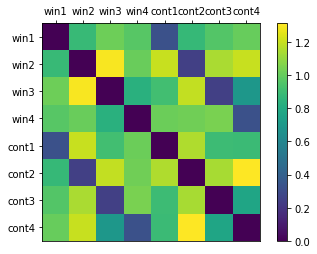

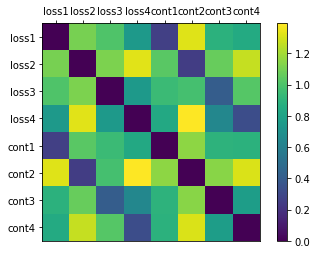

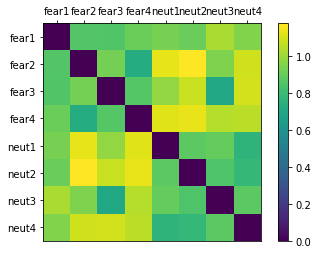

In [ ]:
##### plot RDMs from the RDM_store array to visualize

#### call any combination of sub;task;hemisphere;ROI to visualize RDM (0 - gambling, 1 - emotion/RH - 0, LH - 1, ROIs between 0 and 11 )
subj = 3
hemi = 0
roi = 1

# gambling task win
task = 0
fig, ax = plt.subplots(1,1)
img = ax.imshow(RDM_store[subj][task][hemi][roi])
label_list = [ 'win1','win2', 'win3', 'win4','cont1','cont2','cont3','cont4']
ax.tick_params(bottom=False, top=True, left=True, right=False)
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(label_list)
ax.set_yticklabels(label_list)
fig.colorbar(img)

# gambling task loss
task = 1
fig, ax = plt.subplots(1,1)
img = ax.imshow(RDM_store[subj][task][hemi][roi])
label_list = [ 'loss1','loss2', 'loss3', 'loss4','cont1','cont2','cont3','cont4']
ax.tick_params(bottom=False, top=True, left=True, right=False)
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(label_list)
ax.set_yticklabels(label_list)
fig.colorbar(img)


# emotion task
task = 2
fig, ax = plt.subplots(1,1)
img = ax.imshow(RDM_store[subj][task][hemi][roi])
label_list = ['fear1', 'fear2','fear3','fear4','neut1', 'neut2', 'neut3', 'neut4']
ax.tick_params(bottom=False, top=True, left=True, right=False)
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(label_list)
ax.set_yticklabels(label_list)
fig.colorbar(img)

In [ ]:
### t-test to compare win vs cont, loss vs cont, fear v

In [ ]:
!pip install neurora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 15.6 MB/s 
     |████████████████████████████████| 9.6 MB 55.8 MB/s 
     |████████████████████████████████| 7.5 MB 53.6 MB/s 


In [ ]:
#### RSA on RDMs

import neurora.rdm_corr as neu

def rsa_rdm(rdm1,rdm2):
  corr = neu.rdm_correlation_pearson(rdm1, rdm2, rescale=False, permutation=False, iter=1000)
  return corr

subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

RSA_store1 = np.zeros((100,2,12,2)) # win vs emotion
RSA_store2 = np.zeros((100,2,12,2)) #loss vs emotion
for subjnum in range(len(subjNlist)): # subject
  subID = subjnum
  for i in range(2):
    hemi = i
    for j in range(12):
      roi = j

      # emotion task
      task = 1
      RDMwin = RDM_store[subjnum][0][hemi][roi]
      RDMloss = RDM_store[subjnum][1][hemi][roi]
      # gambling task
      task = 0
      RDMemo = RDM_store[subjnum][2][hemi][roi]

      RSA_store1[subjnum][i][j] = rsa_rdm(RDMwin,RDMemo)
      RSA_store2[subjnum][i][j] = rsa_rdm(RDMloss,RDMemo)

#corr = neu.rdm_correlation_pearson(RDM1, RDM2, rescale=False, permutation=False, iter=1000)

#print(corr.shape)
#print(corr)
#print(RDM1.shape)
#print(RDM2.shape)
print(RSA_store1.shape)

1.577091600453374
(100, 2, 12, 2)


In [ ]:
print(RSA_store1[0][0][1][1])
print(RSA_store1[1][0][1][1])
print(RSA_store2[2][0][1][1])
print(RSA_store2[3][0][1][0])

0.6773539071251263
0.4636280917547748
0.36795535862052364
-0.12645612819973476


[ 2.  2. 13.  7.  4.  3.  7.  4.  3. 16.  6.  2.]
69.0


Text(0, 0.5, 'No. of between-task RDM correlations with r>0.3 or p<0.05')

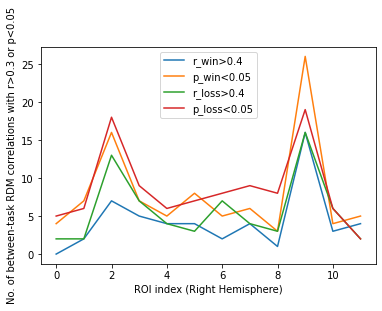

In [ ]:
# RIGHT HEMISPHERE

temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store1[subj][0][roi][0]>0.4:
      temp[roi]+=1
plt.plot(temp)

temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store1[subj][0][roi][1]<0.05:
      temp[roi]+=1
plt.plot(temp)
temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store2[subj][0][roi][0]>0.4:
      temp[roi]+=1
plt.plot(temp)
print(temp)
print(np.sum(temp))

temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store2[subj][0][roi][1]<0.05:
      temp[roi]+=1
plt.plot(temp)
plt.legend(["r_win>0.4", "p_win<0.05","r_loss>0.4", "p_loss<0.05"])
plt.xlabel("ROI index (Right Hemisphere)")
plt.ylabel("No. of between-task RDM correlations with r>0.3 or p<0.05")

[ 5.  2.  9.  9.  8.  9.  5.  5. 16.  7. 15.  8.]
98.0


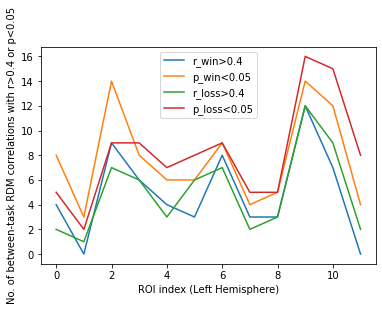

In [ ]:
# LEFT HEMISPHERE


temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store1[subj][1][roi][0]>0.4:
      temp[roi]+=1
plt.plot(temp[LtoRconvert])

temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store1[subj][1][roi][1]<0.05:
      temp[roi]+=1
plt.plot(temp[LtoRconvert])
temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store2[subj][1][roi][0]>0.4:
      temp[roi]+=1
plt.plot(temp[LtoRconvert])

temp=np.zeros(12)
for roi in range(12):
  for subj in range(100):
    #print(RSA_store[subj][0][roi][0])
    if RSA_store2[subj][1][roi][1]<0.05:
      temp[roi]+=1
plt.plot(temp[LtoRconvert])
plt.legend(["r_win>0.4", "p_win<0.05","r_loss>0.4", "p_loss<0.05"])
plt.xlabel("ROI index (Left Hemisphere)")
plt.ylabel("No. of between-task RDM correlations with r>0.4 or p<0.05")
print(temp)
print(np.sum(temp))

In [ ]:
### t-test on RDMs
idx=[1,2,3,4,6,7,8,9,11,12,13,14]
import scipy.stats
subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

test = np.zeros((100,4,2,12,2)) # win vs neut,loss vs neut ,emot , win vs loss
for subj in range(len(subjNlist)):
  subID = subj
  for task in [0,1,2,3]: # win vs neut,loss vs neut ,emot , win vs loss
    for hemi in range(2):
      for bRoi in range(12):
        data = RDM_store[subID][task][hemi][bRoi]
        data_1 = (data[0:4,0:4] + data[4:8,4:8] )/2
        data_2 = data[4:8,0:4]
        test[subID][task][hemi][bRoi] = np.array( scipy.stats.ttest_rel(data_1.reshape(-1)[idx], data_2.reshape(-1)[idx])[:])


Text(0, 0.5, 'No. of within t-test abs(t)>2.80')

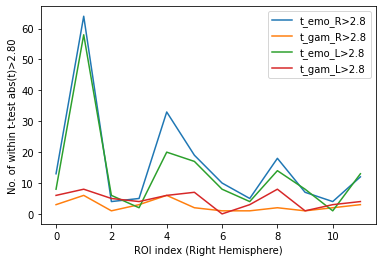

In [ ]:
# T test
t_em_R = np.zeros(12)
t_gam_R = np.zeros(12)
t_em_L = np.zeros(12)
t_gam_L = np.zeros(12)
for broi in range(12):
  t_em_R[broi]=np.sum(np.abs(test[:,2,0,broi,0])>2.8)
  t_gam_R[broi]=np.sum(np.abs(test[:,3,0,broi,0])>2.8)
  t_em_L[broi]=np.sum(np.abs(test[:,2,1,broi,0])>2.8)
  t_gam_L[broi]=np.sum(np.abs(test[:,3,1,broi,0])>2.8)
plt.plot(t_em_R)
plt.plot(t_gam_R)
plt.plot(t_em_L[LtoRconvert])
plt.plot(t_gam_L[LtoRconvert])

plt.legend(["t_emo_R>2.8", "t_gam_R>2.8","t_emo_L>2.8", "t_gam_L>2.8"])
plt.xlabel("ROI index (Right Hemisphere)")
plt.ylabel("No. of within t-test abs(t)>2.80")


# we should check either sim...

Text(0, 0.5, 'No. of within p value < 0.05')

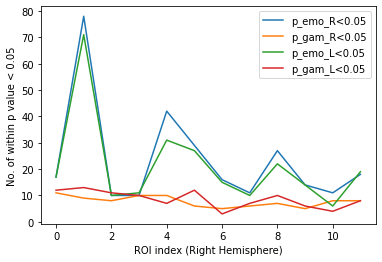

In [ ]:
# T test
p_em_R = np.zeros(12)
p_gam_R = np.zeros(12)
p_em_L = np.zeros(12)
p_gam_L = np.zeros(12)
for broi in range(12):
  p_em_R[broi]=np.sum(np.abs(test[:,2,0,broi,1])<0.05)
  p_gam_R[broi]=np.sum(np.abs(test[:,3,0,broi,1])<0.05)
  p_em_L[broi]=np.sum(np.abs(test[:,2,1,broi,1])<0.05)
  p_gam_L[broi]=np.sum(np.abs(test[:,3,1,broi,1])<0.05)
plt.plot(p_em_R)
plt.plot(p_gam_R)
plt.plot(p_em_L[LtoRconvert])
plt.plot(p_gam_L[LtoRconvert])

plt.legend(["p_emo_R<0.05", "p_gam_R<0.05","p_emo_L<0.05", "p_gam_L<0.05"])
plt.xlabel("ROI index (Right Hemisphere)")
plt.ylabel("No. of within p value < 0.05")

Text(0, 0.5, 'No. of within t-test abs(t)>2.80')

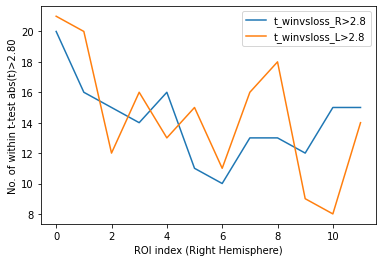

In [ ]:
# T test
t_winvsloss_R = np.zeros(12)
t_winvsloss_L = np.zeros(12)
for broi in range(12):
  t_winvsloss_R[broi]=np.sum(np.abs(test[:,3,0,broi,1])<0.1) # win vs neut,loss vs neut ,emot , win vs loss
  t_winvsloss_L[broi]=np.sum(np.abs(test[:,3,1,broi,1])<0.1) # win vs neut,loss vs neut ,emot , win vs loss
plt.plot(t_winvsloss_R)
plt.plot(t_winvsloss_L[LtoRconvert])

plt.legend(["t_winvsloss_R>2.8", "t_winvsloss_L>2.8"])
plt.xlabel("ROI index (Right Hemisphere)")
plt.ylabel("No. of within t-test abs(t)>2.80")

# PCA

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

import torch
import torch.nn as nn
import numpy as np

timesteps = len(t1[:3]) # time len of each trial
rnn=[[],[],[],[],[],[],[],[],[],[],[],[]]
hidden_size = 1
batch_size = 1 # number of trials
outputs_loss=np.zeros((100,12))
outputs_win=np.zeros((100,12))
subjN = 0
for i in range(12):

  input_size = len(TotalDataSet[subjN][1][0][i])  # No. small roi in big roi
  rnn[i] = nn.RNN(input_size, hidden_size,timesteps)
  h0 = torch.randn(timesteps,hidden_size)
  # subjN ;  gam=0, emotion=1 ; RH = 0, LH =1 ; eachBogROI_num ; smallROI_order ;timeseries (run1 + run2 )
  for subjN in range(100):
    inputs = torch.Tensor(TotalDataSet[subjN][0][0][i][:,t1[:3]].reshape(timesteps,input_size))     #(batch_size, timesteps, input_size)
    output, hn = rnn[i](inputs, h0)
    outputs_loss[subjN,i]=output[-1]

    inputs2 = torch.Tensor(TotalDataSet[subjN][0][0][i][:,t5[:3]].reshape(timesteps,input_size))     #(batch_size, timesteps, input_size)
    output, hn = rnn[i](inputs2, h0)
    outputs_win[subjN,i]=output[-1]


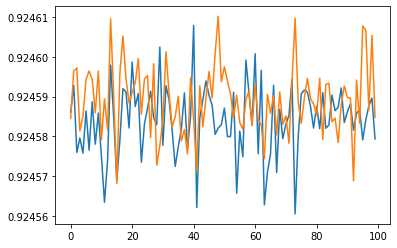

In [ ]:
plt.plot(outputs_loss[:,0]) #visual1
plt.plot(outputs_win[:,0])

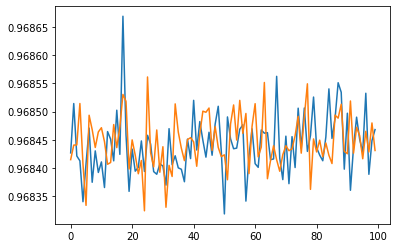

In [ ]:
plt.plot(outputs_loss[:,1]) #visual 2
plt.plot(outputs_win[:,1])

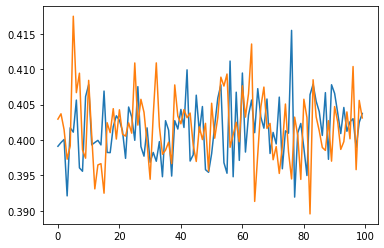

In [ ]:
plt.plot(outputs_loss[:,2]) #3rd roi
plt.plot(outputs_win[:,2])

In [ ]:
# 1. train RNN with emot. data  -> cross validation  for each roi and hemi ==> 12 * 2 models
 # ex) when wou train the RNN, train data set ( subj 0 ~ 79 , all trial, fear ground trouth = 1, neut = 0 ) , valid ( subj 80 ~ 99, in same way)
# 2. test gam. data for each roi and hemi ( conds : win , loss )
# 3. calculate accuracy to compare ground trouth ( estimated win /real win or estimated loss / real loss )

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
loss_r1 = np.array([8.063,11.688,18.899,26.109,29.708,33.319,95.827,99.439,106.663,113.887,117.485,121.097,146.927,154.164])/0.72
loss_r2 = np.array([15.287,55.577,59.189,62.788,70.011,73.623,77.235,95.854,99.466,103.078,110.315,117.539,121.137,146.953,154.164])/0.72+253
win_r1=np.array([15.3,22.511,51.925,59.149,62.774,66.386,69.998,77.222,103.051,110.275,139.703,143.315,150.552,157.776,161.388])/0.72
win_r2=np.array([164.986-253,8.063,11.675,18.899,22.524,26.136,33.359,51.965,139.73,143.342,150.552,157.776,161.388,164.986])/0.72+253

conds=[loss_r1[:7],loss_r1[7:14],loss_r2[:7],loss_r2[7:14],win_r1[:7],win_r1[7:14],win_r2[:7],win_r2[7:14]]

test = np.zeros((100,2,2,12,2))
timelist=[]
for i in range(2): # task
  task = i
  if i == 0: # gambling task (t1 to t4 are loss trials of run1 and run2; t5 to t8 are win trials, run1 and run2)
    for order in range(8):
      temp=np.arange(np.ceil(conds[order][0])+2,np.ceil(conds[order][0])+5)
      for num in conds[order][1:]:
        temp=np.concatenate((temp,np.arange(np.ceil(num)+2,np.ceil(num)+5)))
      timelist.append(temp[:])
    t1=timelist[0] #loss1
    t2=timelist[1] #loss2
    t3=timelist[2] #loss3
    t4=timelist[3] #loss4
    t5=timelist[4] #win1
    t6=timelist[5] #win2
    t7=timelist[6] #win3
    t8=timelist[7] #win4

  else: # emotion task (t1 to t4 are neutral trials of run1 and run2; t5 to t8 are fear trials, run1 and run2)

    t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
    t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
    t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
    t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')
    t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
    t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
    t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
    t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')

In [ ]:
t1=timelist[0] #loss1
t2=timelist[1] #loss2
t3=timelist[2] #loss3
t4=timelist[3] #loss4
t5=timelist[4] #win1
t6=timelist[5] #win2
t7=timelist[6] #win3
t8=timelist[7] #win4

t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')
t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')


print(np.shape(t5))
print(t5)
print(32/0.72)

(25,)
[45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69]
44.44444444444444


In [ ]:
# Emotion roi-wise, sub-wise, trial-wise split: Right Hemisphere

index_list = [[0,1,2],[4,5,6],[8,9,10],[12,13,14],[16,17,18],[20,21,22]]
total_data_1 = []
total_data_2 = []
total_data_3 = []
total_data_4 = []
total_data_5 = []
total_data_6 = []
total_data_7 = []
total_data_8 = []

task = 1
t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')
t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')

total_data_fear_R = []
total_data_neut_R = []

for j in range(12):
  total_data_fear_roi = []
  total_data_neut_roi = []
  for sub in range(100):
    total_data_1 = []
    total_data_2 = []
    total_data_3 = []
    total_data_4 = []
    total_data_5 = []
    total_data_6 = []
    total_data_7 = []
    total_data_8 = []
    for i in range(6):

      data = TotalDataSet[sub][task][0][j][:][:,t5[index_list[i]]]
      total_data_5.append(data) # total_data stores as [trial_index][small ROI_index][time points]
      data = TotalDataSet[sub][task][0][j][:][:,t6[index_list[i]]]
      total_data_6.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t7[index_list[i]]]
      total_data_7.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t8[index_list[i]]]
      total_data_8.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t1[index_list[i]]]
      total_data_1.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t2[index_list[i]]]
      total_data_2.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t3[index_list[i]]]
      total_data_3.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t4[index_list[i]]]
      total_data_4.append(data)

    temp_neutral = np.concatenate((np.array(total_data_5),np.array(total_data_6),np.array(total_data_7),np.array(total_data_8)))
    temp_fear = np.concatenate((np.array(total_data_1),np.array(total_data_2),np.array(total_data_3),np.array(total_data_4)))

    total_data_fear_roi.append(temp_fear)
    total_data_neut_roi.append(temp_neutral)

  total_data_fear_R.append(total_data_fear_roi)
  total_data_neut_R.append(total_data_neut_roi)

    #total_data_fear[sub] = temp_fear
    #total_data_neut[sub] = temp_neutral

#print(total_data_neut)

#print(total_data[0][0])

In [ ]:
# Emotion roi-wise, sub-wise, trial-wise split: Left Hemisphere

index_list = [[0,1,2],[4,5,6],[8,9,10],[12,13,14],[16,17,18],[20,21,22]]
total_data_1 = []
total_data_2 = []
total_data_3 = []
total_data_4 = []
total_data_5 = []
total_data_6 = []
total_data_7 = []
total_data_8 = []

task = 1
t5 = np.arange(np.ceil(32.053/0.72),np.ceil(50.053/0.72)).astype('int') #neut1
t6 = np.arange(np.ceil(74.196/0.72),np.ceil(92.196/0.72)).astype('int')#neut2
t7 = np.arange(np.ceil(176+32.067/0.72),np.ceil(176+50.067/0.72)) .astype('int')
t8 = np.arange(np.ceil(176+74.21/0.72),np.ceil(176+92.21/0.72)).astype('int')
t1 = np.arange(np.ceil(10.982/0.72),np.ceil(28.982/0.72)).astype('int') #fear1
t2 = np.arange(np.ceil(53.138/0.72),np.ceil(71.138/0.72)) .astype('int') #fear2
t3 = np.arange(np.ceil(10.982/0.72+176),np.ceil(28.982/0.72+176)).astype('int')
t4 = np.arange(np.ceil(53.138/0.72+176),np.ceil(71.138/0.72+176)).astype('int')

total_data_fear_L = []
total_data_neut_L = []

for j in [0,1,2,3,9,4,5,6,7,8,10,11]:
  total_data_fear_roi = []
  total_data_neut_roi = []
  for sub in range(100):
    total_data_1 = []
    total_data_2 = []
    total_data_3 = []
    total_data_4 = []
    total_data_5 = []
    total_data_6 = []
    total_data_7 = []
    total_data_8 = []
    for i in range(6):

      data = TotalDataSet[sub][task][1][j][:][:,t5[index_list[i]]]
      total_data_5.append(data) # total_data stores as [trial_index][small ROI_index][time points]
      data = TotalDataSet[sub][task][1][j][:][:,t6[index_list[i]]]
      total_data_6.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t7[index_list[i]]]
      total_data_7.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t8[index_list[i]]]
      total_data_8.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t1[index_list[i]]]
      total_data_1.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t2[index_list[i]]]
      total_data_2.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t3[index_list[i]]]
      total_data_3.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t4[index_list[i]]]
      total_data_4.append(data)

    temp_neutral = np.concatenate((np.array(total_data_5),np.array(total_data_6),np.array(total_data_7),np.array(total_data_8)))
    temp_fear = np.concatenate((np.array(total_data_1),np.array(total_data_2),np.array(total_data_3),np.array(total_data_4)))

    total_data_fear_roi.append(temp_fear)
    total_data_neut_roi.append(temp_neutral)

  total_data_fear_L.append(total_data_fear_roi)
  total_data_neut_L.append(total_data_neut_roi)

    #total_data_fear[sub] = temp_fear
    #total_data_neut[sub] = temp_neutral

#print(total_data_neut)

#print(total_data[0][0])

In [ ]:
print(np.shape(total_data_fear_R[9]))

(100, 24, 40, 3)


In [ ]:
loss_r1 = np.array([8.063,11.688,18.899,26.109,29.708,33.319,95.827,99.439,106.663,113.887,117.485,121.097,146.927,154.164])/0.72
loss_r2 = np.array([15.287,55.577,59.189,62.788,70.011,73.623,77.235,95.854,99.466,103.078,110.315,117.539,121.137,146.953,154.164])/0.72+253
win_r1=np.array([15.3,22.511,51.925,59.149,62.774,66.386,69.998,77.222,103.051,110.275,139.703,143.315,150.552,157.776,161.388])/0.72
win_r2=np.array([164.986-253,8.063,11.675,18.899,22.524,26.136,33.359,51.965,139.73,143.342,150.552,157.776,161.388,164.986])/0.72+253

conds=[loss_r1[:7],loss_r1[7:14],loss_r2[:7],loss_r2[7:14],win_r1[:7],win_r1[7:14],win_r2[:7],win_r2[7:14]]

timelist=[]

for i in range(2): # task
  task = i
  if i == 0: # gambling task (t1 to t4 are loss trials of run1 and run2; t5 to t8 are win trials, run1 and run2)
    for order in range(8):
      temp=np.arange(np.ceil(conds[order][0])+2,np.ceil(conds[order][0])+5)
      for num in conds[order][1:]:
        temp=np.concatenate((temp,np.arange(np.ceil(num)+2,np.ceil(num)+5)))
      timelist.append(temp[:])
    t1=timelist[0] #loss1
    t2=timelist[1] #loss2
    t3=timelist[2] #loss3
    t4=timelist[3] #loss4
    t5=timelist[4] #win1
    t6=timelist[5] #win2
    t7=timelist[6] #win3
    t8=timelist[7] #win4

In [ ]:
# Gambling roi-wise, sub-wise, trial-wise split: Right Hemisphere

index_list = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16,17],[18,19,20]]

t1=timelist[0].astype(int) #loss1
t2=timelist[1].astype(int) #loss2
t3=timelist[2].astype(int) #loss3
t4=timelist[3].astype(int) #loss4
t5=timelist[4].astype(int) #win1
t6=timelist[5].astype(int) #win2
t7=timelist[6].astype(int) #win3
t8=timelist[7].astype(int) #win4

total_data_1 = []
total_data_2 = []
total_data_3 = []
total_data_4 = []
total_data_5 = []
total_data_6 = []
total_data_7 = []
total_data_8 = []

task = 0

total_data_win_R = []
total_data_loss_R = []
for j in range(12):
  total_data_win_roi = []
  total_data_loss_roi = []
  for sub in range(100):
    total_data_1 = []
    total_data_2 = []
    total_data_3 = []
    total_data_4 = []
    total_data_5 = []
    total_data_6 = []
    total_data_7 = []
    total_data_8 = []
    for i in range(6):

      data = TotalDataSet[sub][task][0][j][:][:,t5[index_list[i]]]
      total_data_5.append(data) # total_data stores as [trial_index][small ROI_index][time points]
      data = TotalDataSet[sub][task][0][j][:][:,t6[index_list[i]]]
      total_data_6.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t7[index_list[i]]]
      total_data_7.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t8[index_list[i]]]
      total_data_8.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t1[index_list[i]]]
      total_data_1.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t2[index_list[i]]]
      total_data_2.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t3[index_list[i]]]
      total_data_3.append(data)
      data = TotalDataSet[sub][task][0][j][:][:,t4[index_list[i]]]
      total_data_4.append(data)

    temp_win = np.concatenate((np.array(total_data_5),np.array(total_data_6),np.array(total_data_7),np.array(total_data_8)))
    temp_loss = np.concatenate((np.array(total_data_1),np.array(total_data_2),np.array(total_data_3),np.array(total_data_4)))

    total_data_win_roi.append(temp_win)
    total_data_loss_roi.append(temp_loss)

  total_data_win_R.append(total_data_win_roi)
  total_data_loss_R.append(total_data_loss_roi)

In [ ]:
# Gambling roi-wise, sub-wise, trial-wise split: Left Hemisphere

index_list = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16,17],[18,19,20]]

t1=timelist[0].astype(int) #loss1
t2=timelist[1].astype(int) #loss2
t3=timelist[2].astype(int) #loss3
t4=timelist[3].astype(int) #loss4
t5=timelist[4].astype(int) #win1
t6=timelist[5].astype(int) #win2
t7=timelist[6].astype(int) #win3
t8=timelist[7].astype(int) #win4

total_data_1 = []
total_data_2 = []
total_data_3 = []
total_data_4 = []
total_data_5 = []
total_data_6 = []
total_data_7 = []
total_data_8 = []

task = 0

total_data_win_L = []
total_data_loss_L = []

for j in [0,1,2,3,9,4,5,6,7,8,10,11]:
  total_data_win_roi = []
  total_data_loss_roi = []
  for sub in range(100):
    total_data_1 = []
    total_data_2 = []
    total_data_3 = []
    total_data_4 = []
    total_data_5 = []
    total_data_6 = []
    total_data_7 = []
    total_data_8 = []
    for i in range(6):

      data = TotalDataSet[sub][task][1][j][:][:,t5[index_list[i]]]
      total_data_5.append(data) # total_data stores as [trial_index][small ROI_index][time points]
      data = TotalDataSet[sub][task][1][j][:][:,t6[index_list[i]]]
      total_data_6.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t7[index_list[i]]]
      total_data_7.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t8[index_list[i]]]
      total_data_8.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t1[index_list[i]]]
      total_data_1.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t2[index_list[i]]]
      total_data_2.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t3[index_list[i]]]
      total_data_3.append(data)
      data = TotalDataSet[sub][task][1][j][:][:,t4[index_list[i]]]
      total_data_4.append(data)

    temp_win = np.concatenate((np.array(total_data_5),np.array(total_data_6),np.array(total_data_7),np.array(total_data_8)))
    temp_loss = np.concatenate((np.array(total_data_1),np.array(total_data_2),np.array(total_data_3),np.array(total_data_4)))

    total_data_win_roi.append(temp_win)
    total_data_loss_roi.append(temp_loss)

  total_data_win_L.append(total_data_win_roi)
  total_data_loss_L.append(total_data_loss_roi)


In [ ]:
print(np.shape(total_data_fear_R[9])) ## total_data_win_R etc. stores as [bRoi][sub][total trials][small ROI][time]
print(np.shape(total_data_neut_L[9]))

(100, 24, 40, 3)
(100, 24, 40, 3)


total_data_fear_R
total_data_fear_L
total_data_neut_R
total_data_neut_L

total_data_win_R
total_data_win_L
total_data_loss_R
total_data_loss_L

For each task-condition and each hemisphere:
[bRoi][subID][total trials][small ROI][time points]

In [ ]:
### Random Forest Classifier: Emotion Task
### stores models in clf_list_R_em, clf_list_L_em, and model performance in acc_R_roi_em, prec_R_roi_em, etc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score
import pandas as pd
import random

acc_R_roi_em = np.zeros(12)
acc_L_roi_em = np.zeros(12)
prec_R_roi_em = np.zeros(12)
prec_L_roi_em = np.zeros(12)

clf_list_R_em = []
clf_list_L_em = []

for bRoi in range(12):
  #bRoi = 9
  index_list = np.linspace(0, 3839, num=3840).astype(int)

  random.seed(bRoi)
  np.random.shuffle(index_list)

  # Training data split

  X_train_fear_R = np.array(total_data_fear_R[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_neut_R = np.array(total_data_neut_R[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_fear_L = np.array(total_data_fear_L[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_neut_L = np.array(total_data_neut_L[bRoi][0:80][:][:][:]).reshape(1920,-1)

  y_train_fear_R = np.zeros(len(X_train_fear_R)) #labels (fear = 0, neut = 1)
  y_train_neut_R = np.ones(len(X_train_neut_R)) #labels
  y_train_fear_L = np.zeros(len(X_train_fear_L)) #labels
  y_train_neut_L = np.ones(len(X_train_neut_L)) #labels

  X_train_R = np.concatenate((X_train_fear_R, X_train_neut_R)) # total no. training trials = 1920 + 1920 = 3840
  y_train_R = np.concatenate((y_train_fear_R, y_train_neut_R))
  X_train_R = X_train_R[index_list]
  y_train_R = y_train_R[index_list]

  X_train_L = np.concatenate((X_train_fear_L, X_train_neut_L))
  y_train_L = np.concatenate((y_train_fear_L, y_train_neut_L))
  X_train_L= X_train_L[index_list]
  y_train_L = y_train_L[index_list]

  # Testing data split
  index_list_test = np.linspace(0, 959, num=960).astype(int)

  random.seed(bRoi)
  np.random.shuffle(index_list_test)

  X_test_fear_R = np.array(total_data_fear_R[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_neut_R = np.array(total_data_neut_R[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_fear_L = np.array(total_data_fear_L[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_neut_L = np.array(total_data_neut_L[bRoi][80:100][:][:][:]).reshape(480,-1)

  y_test_fear_R = np.zeros(len(X_test_fear_R)) #labels (fear = 0, neut = 1)
  y_test_neut_R = np.ones(len(X_test_neut_R)) #labels
  y_test_fear_L = np.zeros(len(X_test_fear_L)) #labels
  y_test_neut_L = np.ones(len(X_test_neut_L)) #labels

  X_test_R = np.concatenate((X_test_fear_R, X_test_neut_R)) # total no. testing trials = 480 + 480 = 960
  y_test_R = np.concatenate((y_test_fear_R, y_test_neut_R))
  X_test_R = X_test_R[index_list_test]
  y_test_R = y_test_R[index_list_test]

  X_test_L = np.concatenate((X_test_fear_L, X_test_neut_L))
  y_test_L = np.concatenate((y_test_fear_L, y_test_neut_L))
  X_test_L = X_test_L[index_list_test]
  y_test_L = y_test_L[index_list_test]

  # creating a RF classifier

  clf_R = RandomForestClassifier(n_estimators = 100)
  clf_L = RandomForestClassifier(n_estimators = 100)

  # training classifier: Right Hemisphere

  clf_R.fit(X_train_R, y_train_R)
  clf_list_R_em.append(clf_R)


  # testing classifier: Right Hemisphere

  y_pred_R = clf_R.predict(X_test_R)
  acc_R = metrics.accuracy_score(y_test_R, y_pred_R, normalize=True)

  # training classifier: Left Hemisphere

  clf_L.fit(X_train_L, y_train_L)
  clf_list_L_em.append(clf_L)

  # testing classifier: Left Hemisphere

  y_pred_L = clf_L.predict(X_test_L)
  acc_L = metrics.accuracy_score(y_test_L, y_pred_L,normalize=True)

  precision_R = precision_score(y_test_R, y_pred_R, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
  precision_L = precision_score(y_test_L, y_pred_L, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

  acc_R_roi_em[bRoi] = acc_R
  acc_L_roi_em[bRoi] = acc_L
  prec_R_roi_em[bRoi] = precision_R
  prec_L_roi_em[bRoi] = precision_L



#print(acc_R)
#print(acc_L)
#print(precision_R)
#print(precision_L)

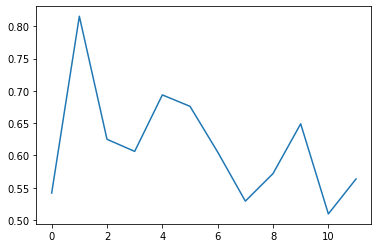

In [ ]:
plt.plot(acc_R_roi_em)

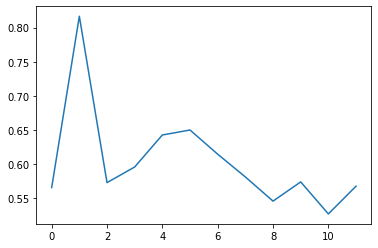

In [ ]:
plt.plot(acc_L_roi_em[LtoRconvert])

In [ ]:
### Random Forest Classifier: Gambling Task
### stores models in clf_list_R_gam, clf_list_L_gam, and model performance in acc_R_roi_gam, prec_R_roi_gam, etc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score
import pandas as pd
import random

acc_R_roi_gam = np.zeros(12)
acc_L_roi_gam = np.zeros(12)
prec_R_roi_gam = np.zeros(12)
prec_L_roi_gam = np.zeros(12)

clf_list_R_gam = []
clf_list_L_gam = []

for bRoi in range(12):
  #bRoi = 9
  index_list = np.linspace(0, 3839, num=3840).astype(int)

  random.seed(bRoi)
  np.random.shuffle(index_list)

  # Training data split

  X_train_win_R = np.array(total_data_win_R[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_loss_R = np.array(total_data_loss_R[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_win_L = np.array(total_data_win_L[bRoi][0:80][:][:][:]).reshape(1920,-1)
  X_train_loss_L = np.array(total_data_loss_L[bRoi][0:80][:][:][:]).reshape(1920,-1)

  y_train_win_R = np.zeros(len(X_train_win_R)) #labels (win = 0, loss = 1)
  y_train_loss_R = np.ones(len(X_train_loss_R)) #labels
  y_train_win_L = np.zeros(len(X_train_win_L)) #labels
  y_train_loss_L = np.ones(len(X_train_loss_L)) #labels

  X_train_R = np.concatenate((X_train_win_R, X_train_loss_R)) # total no. training trials = 1920 + 1920 = 3840
  y_train_R = np.concatenate((y_train_win_R, y_train_loss_R))
  X_train_R = X_train_R[index_list]
  y_train_R = y_train_R[index_list]

  X_train_L = np.concatenate((X_train_win_L, X_train_loss_L))
  y_train_L = np.concatenate((y_train_win_L, y_train_loss_L))
  X_train_L= X_train_L[index_list]
  y_train_L = y_train_L[index_list]

  # Testing data split
  index_list_test = np.linspace(0, 959, num=960).astype(int)

  random.seed(bRoi)
  np.random.shuffle(index_list_test)

  X_test_win_R = np.array(total_data_win_R[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_loss_R = np.array(total_data_loss_R[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_win_L = np.array(total_data_win_L[bRoi][80:100][:][:][:]).reshape(480,-1)
  X_test_loss_L = np.array(total_data_loss_L[bRoi][80:100][:][:][:]).reshape(480,-1)

  y_test_win_R = np.zeros(len(X_test_win_R)) #labels (fear = 0, neut = 1)
  y_test_loss_R = np.ones(len(X_test_loss_R)) #labels
  y_test_win_L = np.zeros(len(X_test_win_L)) #labels
  y_test_loss_L = np.ones(len(X_test_loss_L)) #labels

  X_test_R = np.concatenate((X_test_win_R, X_test_loss_R)) # total no. testing trials = 480 + 480 = 960
  y_test_R = np.concatenate((y_test_win_R, y_test_loss_R))
  X_test_R = X_test_R[index_list_test]
  y_test_R = y_test_R[index_list_test]

  X_test_L = np.concatenate((X_test_win_L, X_test_loss_L))
  y_test_L = np.concatenate((y_test_win_L, y_test_loss_L))
  X_test_L = X_test_L[index_list_test]
  y_test_L = y_test_L[index_list_test]

  # creating a RF classifier

  clf_R = RandomForestClassifier(n_estimators = 100)
  clf_L = RandomForestClassifier(n_estimators = 100)

  # training classifier: Right Hemisphere

  clf_R.fit(X_train_R, y_train_R)
  clf_list_R_gam.append(clf_R)

  # testing classifier: Right Hemisphere

  y_pred_R = clf_R.predict(X_test_R)
  acc_R = metrics.accuracy_score(y_test_R, y_pred_R, normalize=True)

  # training classifier: Left Hemisphere

  clf_L.fit(X_train_L, y_train_L)
  clf_list_L_gam.append(clf_L)

  # testing classifier: Left Hemisphere

  y_pred_L = clf_L.predict(X_test_L)
  acc_L = metrics.accuracy_score(y_test_L, y_pred_L,normalize=True)

  precision_R = precision_score(y_test_R, y_pred_R, labels=None, pos_label=0, average='binary', sample_weight=None, zero_division='warn')
  precision_L = precision_score(y_test_L, y_pred_L, labels=None, pos_label=0, average='binary', sample_weight=None, zero_division='warn')

  acc_R_roi_gam[bRoi] = acc_R
  acc_L_roi_gam[bRoi] = acc_L
  prec_R_roi_gam[bRoi] = precision_R
  prec_L_roi_gam[bRoi] = precision_L

#print(acc_R)
#print(acc_L)
#print(precision_R)
#print(precision_L)

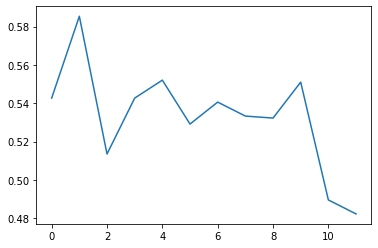

In [ ]:
plt.plot(acc_R_roi_gam)

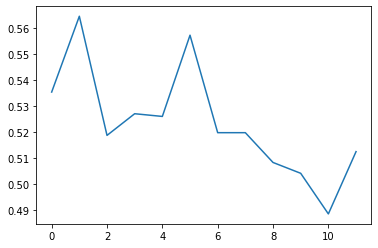

In [ ]:
plt.plot(acc_L_roi_gam[LtoRconvert])

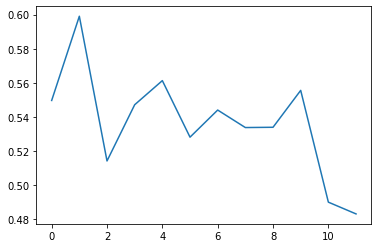

In [ ]:
plt.plot(prec_R_roi_gam)

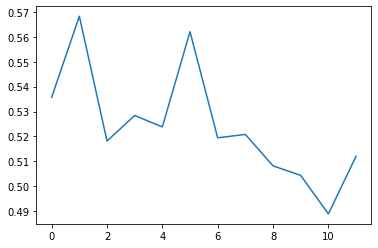

In [ ]:
plt.plot(prec_L_roi_gam[LtoRconvert])

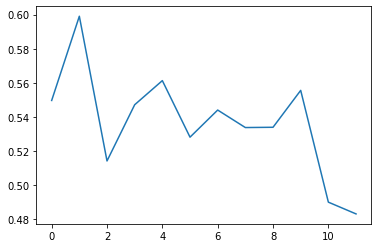

In [ ]:
plt.plot(prec_R_roi_gam)

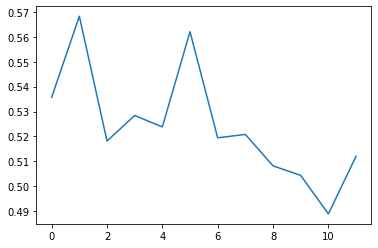

In [ ]:
plt.plot(prec_L_roi_gam[LtoRconvert])

In [ ]:
### Random Forest Classifier: Trained with Emotion, Test with Gambling
### stores model performance in acc_R_roi_gam_test, prec_R_roi_gam_test, etc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score
import pandas as pd
import random

acc_R_roi_gam_test = np.zeros(12)
acc_L_roi_gam_test = np.zeros(12)
prec_R_roi_gam_test = np.zeros(12)
prec_L_roi_gam_test = np.zeros(12)

for bRoi in range(12):
  #bRoi = 9

  # Testing data split
  index_list_test = np.linspace(0, 959, num=960).astype(int)

  random.seed(bRoi)
  np.random.shuffle(index_list_test)

  X_test_win_R = np.array(total_data_win_R[bRoi][20:40][:][:][:]).reshape(480,-1)
  X_test_loss_R = np.array(total_data_loss_R[bRoi][20:40][:][:][:]).reshape(480,-1)
  X_test_win_L = np.array(total_data_win_L[bRoi][20:40][:][:][:]).reshape(480,-1)
  X_test_loss_L = np.array(total_data_loss_L[bRoi][20:40][:][:][:]).reshape(480,-1)

  y_test_win_R = np.zeros(len(X_test_win_R)) #labels (win = 0, loss = 1)
  y_test_loss_R = np.ones(len(X_test_loss_R)) #labels
  y_test_win_L = np.zeros(len(X_test_win_L)) #labels
  y_test_loss_L = np.ones(len(X_test_loss_L)) #labels

  X_test_R = np.concatenate((X_test_win_R, X_test_loss_R)) # total no. testing trials = 480 + 480 = 960
  y_test_R = np.concatenate((y_test_win_R, y_test_loss_R))
  X_test_R = X_test_R[index_list_test]
  y_test_R = y_test_R[index_list_test]

  X_test_L = np.concatenate((X_test_win_L, X_test_loss_L))
  y_test_L = np.concatenate((y_test_win_L, y_test_loss_L))
  X_test_L = X_test_L[index_list_test]
  y_test_L = y_test_L[index_list_test]

  # creating a emotion-trained RF classifier
  clf_R_gam_test = clf_list_R_em[bRoi]

  # testing on gambling: Right Hemisphere

  y_pred_R = clf_R_gam_test.predict(X_test_R)
  acc_R = metrics.accuracy_score(y_test_R, y_pred_R, normalize=True)

  # creating a emotion-trained RF classifier
  clf_L_gam_test = clf_list_L_em[bRoi]

  # testing on gambling: Right Hemisphere

  y_pred_L = clf_L_gam_test.predict(X_test_L)
  acc_L = metrics.accuracy_score(y_test_L, y_pred_L, normalize=True)

  precision_R = precision_score(y_test_R, y_pred_R, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
  precision_L = precision_score(y_test_L, y_pred_L, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

  acc_R_roi_gam_test[bRoi] = acc_R
  acc_L_roi_gam_test[bRoi] = acc_L
  prec_R_roi_gam_test[bRoi] = precision_R
  prec_L_roi_gam_test[bRoi] = precision_L

#print(acc_R)
#print(acc_L)
#print(precision_R)
#print(precision_L)

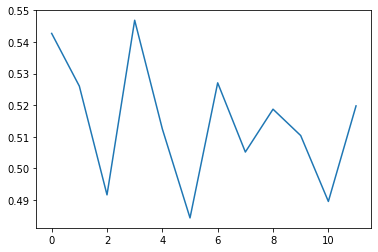

In [ ]:
plt.plot(acc_R_roi_gam_test)

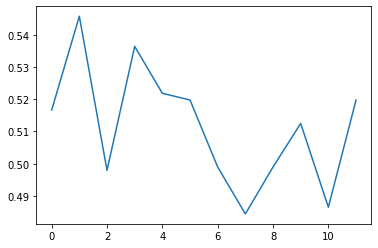

In [ ]:
plt.plot(acc_L_roi_gam_test[LtoRconvert])

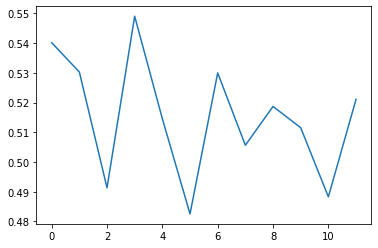

In [ ]:
plt.plot(prec_R_roi_gam_test)

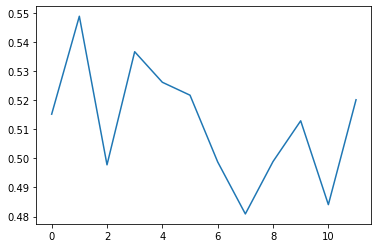

In [ ]:
plt.plot(prec_L_roi_gam_test[LtoRconvert])

[Text(0.6696213400900901, 0.9761904761904762, 'X[27] <= 1.003\ngini = 0.5\nsamples = 2436\nvalue = [1952, 1888]'),
 Text(0.48735078828828826, 0.9285714285714286, 'X[29] <= 1.003\ngini = 0.44\nsamples = 1441\nvalue = [1551, 754]'),
 Text(0.35335022522522525, 0.8809523809523809, 'X[19] <= 1.002\ngini = 0.378\nsamples = 1133\nvalue = [1361, 460]'),
 Text(0.27548423423423424, 0.8333333333333334, 'X[11] <= 1.003\ngini = 0.433\nsamples = 767\nvalue = [855, 398]'),
 Text(0.17943693693693694, 0.7857142857142857, 'X[68] <= 0.999\ngini = 0.419\nsamples = 700\nvalue = [804, 343]'),
 Text(0.08981981981981982, 0.7380952380952381, 'X[20] <= 0.998\ngini = 0.482\nsamples = 360\nvalue = [348, 238]'),
 Text(0.043423423423423424, 0.6904761904761905, 'X[3] <= 0.997\ngini = 0.499\nsamples = 197\nvalue = [154, 165]'),
 Text(0.0190990990990991, 0.6428571428571429, 'X[41] <= 0.99\ngini = 0.397\nsamples = 74\nvalue = [88, 33]'),
 Text(0.005765765765765766, 0.5952380952380952, 'X[1] <= 0.975\ngini = 0.14\nsampl

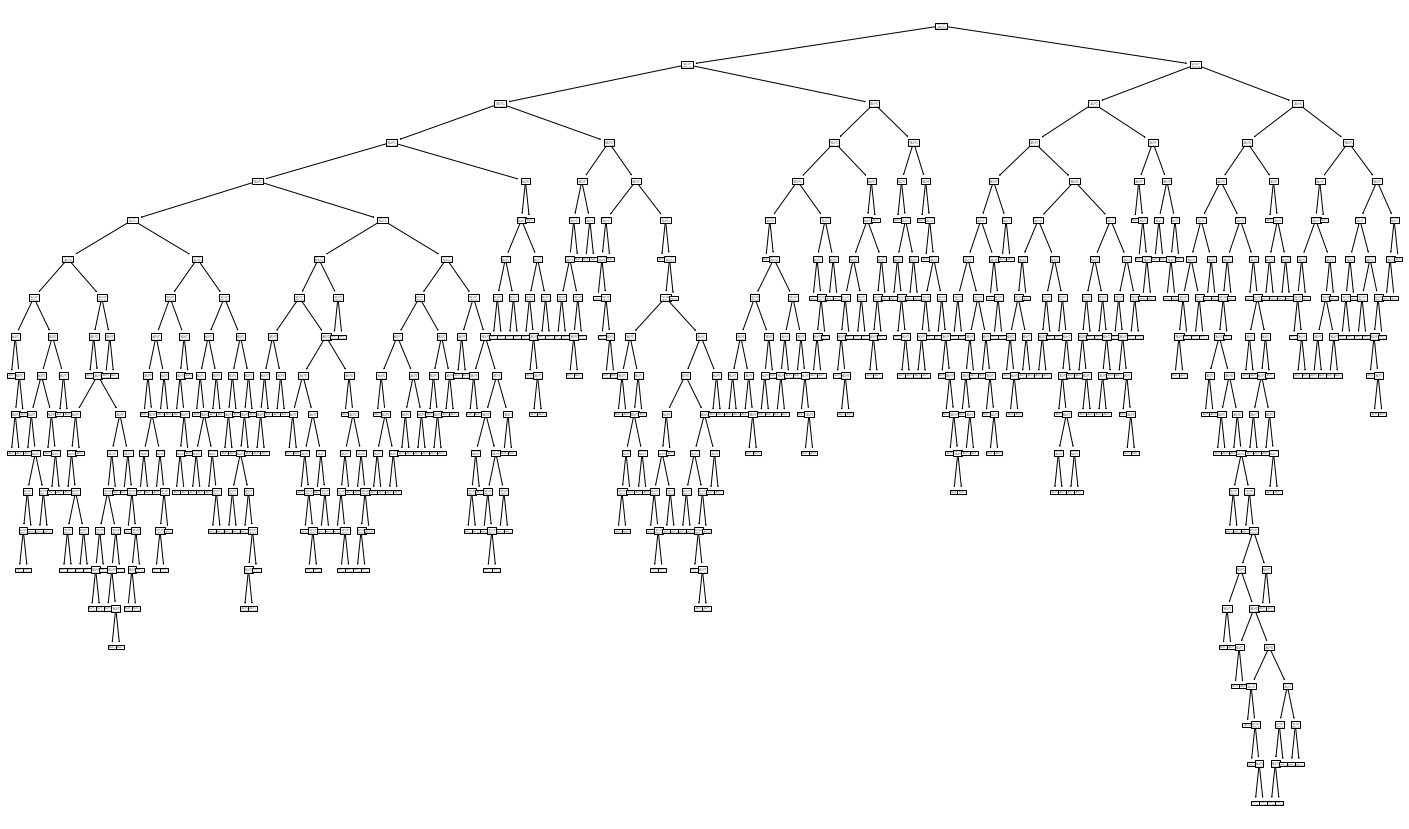

In [ ]:
from sklearn.tree import plot_tree

clf = clf_list_R_em[1]
fig = plt.figure(figsize=(25, 15))
plot_tree(clf.estimators_[0])



## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:

def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"]/ TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [ ]:
## storing frames for gambling task (0 - loss, 1 - win, 2 - neutral)

subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

print(subjNlist[1])
#frame_gm = np.zeros((100,2,))
frame_gm_r1 = []
frame_gm_r2 = []

for i in range(len(subjNlist)):
  for run in range(2):
    if run == 0:
      frame_gm_r1.append(load_evs(subjNlist[i], "GAMBLING", run))
    else:
      frame_gm_r2.append(load_evs(subjNlist[i], "GAMBLING", run))

In [ ]:
print(np.shape(frame_gm_r1))
print(np.shape(frame_gm_r1[0][2]))

In [ ]:
## storing frames for emotion task (0 - loss, 1 - win)

subjf=open('/content/hcp_task/subjects_list.txt','r')
for i in subjf:
  subjNlist=i.split()
  break

print(subjNlist[1])
#frame_gm = np.zeros((100,2,))
frame_em_r1 = []
frame_em_r2 = []

for i in range(len(subjNlist)):
  for run in range(2):
    if run == 0:
      frame_em_r1.append(load_evs(subjNlist[i], "EMOTION", run))
    else:
      frame_em_r2.append(load_evs(subjNlist[i], "EMOTION", run))

In [ ]:
np.shape(frame_em_r1)
print(np.shape(frame_em_r1))

In [ ]:
print(np.shape(frame_gm_r1))
print(frame_gm_r1[0][2][0])

In [ ]:
### Frames for each task and run (subID, condition, block, frames)
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate(np.mean(data[:, evs[idx]], axis=1, keepdims=True), axis=-1), axis=1)


#lf_activity = average_frames(data, evs, my_exp, 'loss')
#rf_activity = average_frames(data, evs, my_exp, 'win')
#contrast = lf_activity - rf_activity  # difference between left and right hand movemen

subID = 0
loss = 0
win = 1
neut = 2
for i in range(2): # block number
  frame = frame_gm_r1[subID][loss][i]
  data = TotalDataSet[subID][0][0][1][:,frame]
  average_data =
print(data.shape)

In [ ]:
np.shape(TotalDataSet)

In [ ]:
import os
def load_single_timeseries_evs(subject, experiment, run, remove_mean=True,txtname=''):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """

  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}/EVs"
  #print(os.listdir(f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"))
  bold_file = txtname
  ts = open(f"{bold_path}/{bold_file}",'r')
  txt=[]
  for i in ts:
    txt.append(i)
  return txt


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    print(cond)
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    print(ev)
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    print(start)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
data=load_evs(subject=my_subj,
                              experiment=my_exp,
                              run=0)
data

In [ ]:
data=load_evs(subject=my_subj,
                              experiment=my_exp,
                              run=1)
data

In [ ]:
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='win_event.txt')

In [ ]:
my_exp = 'GAMBLING'
my_subj = subjects[1]
my_run = 1
dirlists=['win.txt', 'loss.txt', 'neut_event.txt', 'loss_event.txt', 'Sync.txt', 'win_event.txt', 'Stats.txt']
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='win_event.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='neut_event.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='loss_event.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='Stats.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='win.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='neut_event.txt')
print(data)
data = load_single_timeseries_evs(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True,txtname='loss.txt')
print(data)

In [ ]:
data

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [ ]:
EXPERIMENTS['GAMBLING']['cond']

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


lf_activity = average_frames(data, evs, my_exp, 'loss')
rf_activity = average_frames(data, evs, my_exp, 'win')
contrast = lf_activity - rf_activity  # difference between left and right hand movement

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='loss')
plt.plot(rf_activity,label='win')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
df = pd.DataFrame({'loss' : lf_activity,
                   'win' : rf_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='loss', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='win', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'loss')
    rf_activity = average_frames(data, evs, my_exp, 'win')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
!pip install nilearn

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

In [ ]:
#CNN

In [ ]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt